<a href="https://colab.research.google.com/github/CarloLonghi/SKAChallenge/blob/main/50_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from astropy.io import fits
from numpy.lib.function_base import _calculate_shapes
import pandas as pd
import os
import math
from matplotlib import pyplot as plt

Mount google drive and set the path where our data is stored. We can also use local files but they are slower to upload

In [3]:
from google.colab import drive
drive.mount('/content/drive')

dir_path = "drive/MyDrive/DL/"

Mounted at /content/drive


Get the fits file from the drive and extract the image

In [4]:
fits_img = fits.open(dir_path + "SKAMid_B1_8h_v3.fits")
print(fits_img.info())
fits_img = fits_img[0].data[0,0,:,:]
fits_img = fits_img[16300:20300,16300:20300]

Filename: drive/MyDrive/DL/SKAMid_B1_8h_v3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     118   (32768, 32768, 1, 1)   float32   
None


Parameter settings:

*   since, when using the entire image the RAM of the system fills easily, we can use the image_size variable to work only on a portion of the image
*   cutout_size is the size of the squares in which the image is divided


In [5]:
cutout_size = 52
image_size = 4000
cutouts_per_row = image_size//cutout_size

**Data Normalization**

In [6]:
f = fits_img.flatten()
avg = np.mean(f)
std = np.mean(f)
fits_img = (fits_img - avg) / std

Divide the image

In [7]:
cutouts = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    cutouts[i*cutouts_per_row+j] = fits_img[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del fits_img

Upload the already filtered training set from the drive

In [8]:
FilteredTrainingSet=pd.read_csv(dir_path + "filtered_training_set.csv",)
#FilteredTrainingSet=pd.read_csv(dir_path + "TrainingSet_B1_v2.txt",skiprows=17,delimiter='\s+')
FilteredTrainingSet=FilteredTrainingSet[FilteredTrainingSet.columns[0:15]]
FilteredTrainingSet.columns=['ID','RA (core)','DEC (core)','RA (centroid)','DEC (centroid)','FLUX','Core frac','BMAJ','BMIN','PA','SIZE','CLASS','SELECTION','x','y']
FilteredTrainingSet['x']=FilteredTrainingSet['x'].astype(int)
FilteredTrainingSet['y']=FilteredTrainingSet['y'].astype(int)
FilteredTrainingSet['x']=FilteredTrainingSet['x']-16300
FilteredTrainingSet['y']=FilteredTrainingSet['y']-16300
FilteredTrainingSet = FilteredTrainingSet.set_index('ID')
print(np.min(FilteredTrainingSet['y']),np.max(FilteredTrainingSet['y']),np.min(FilteredTrainingSet['x']),np.max(FilteredTrainingSet['x']))

432 3620 83 3570


Generate images from the training set where each dot corresponds to a source

In [9]:
data=np.zeros((image_size,image_size,3), dtype=np.uint8 )
for i in range(0,len(FilteredTrainingSet)):
  x = int(FilteredTrainingSet['x'].iloc[i])
  y = int(FilteredTrainingSet['y'].iloc[i])
  c = int(FilteredTrainingSet['CLASS'].iloc[i]) - 1
  data[y,x,c] = 1

In [10]:
background = np.ones((image_size, image_size, 1), dtype = np.uint8)
for i in range(0,len(FilteredTrainingSet)):
  x = int(FilteredTrainingSet['x'].iloc[i])
  y = int(FilteredTrainingSet['y'].iloc[i])
  background [y,x] = 0

data = np.concatenate((data,background), axis = 2)
np.shape(data)

(4000, 4000, 4)

Divide the data generated images

In [11]:
data_array = np.empty((cutouts_per_row**2,cutout_size,cutout_size,4))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    data_array[i*cutouts_per_row+j] = data[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del data

In [12]:
from tensorflow.keras.layers import  Resizing, Input, Dense, Conv2D, Dropout, BatchNormalization, MaxPool2D, UpSampling2D, RandomFlip, RandomRotation, Rescaling, RandomTranslation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import regularizers

Divide the dataset in train,validation and test sets

In [13]:
train_x, test_x, train_y, test_y = train_test_split(cutouts, data_array, test_size=0.2, random_state=42,shuffle=True)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42,shuffle=True)

Define custom layer for REFLECT padding

In [14]:
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow 

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tensorflow.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'padding' : self.padding
        })
        return config

In [15]:
IMG_SIZE = 208

resize_rescale_flip_rotate = Sequential([
  
  #Rescaling(1./255),
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
  RandomTranslation(0.1,0.1),
  RandomRotation(0.3),
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
  RandomTranslation(0.1,0.1),
])

Define the model

In [16]:
input_layer = Input(shape=(cutout_size, cutout_size, 1))
x = resize_rescale_flip_rotate(input_layer)
#x = Resizing(IMG_SIZE, IMG_SIZE)(x)
x = resize_rescale_flip_rotate(x)
x = ReflectionPadding2D(padding = (3,3))(input_layer)
#dropout batch normalization
x = Conv2D(16, (7, 7), strides=1, activation='relu')(x)
#x = MaxPool2D((2,2))(x)
x = ReflectionPadding2D(padding = (2,2))(x)
x = Conv2D(32, (5, 5), strides=1, activation='relu')(x)
#x = MaxPool2D((2,2))(x)
x = ReflectionPadding2D(padding = (1,1))(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
output_layer = Dense(4,activation='softmax')(x)

myCNN = Model(input_layer,output_layer)
adadelta = optimizers.Adadelta(learning_rate=1.0, decay=0.0, rho=0.99)
nadam = optimizers.Nadam()
adam = optimizers.Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999, epsilon=1e-07,)
myCNN.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

print(myCNN.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 52, 52, 1)]       0         
_________________________________________________________________
reflection_padding2d (Reflec (None, 58, 58, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 52, 52, 16)        800       
_________________________________________________________________
reflection_padding2d_1 (Refl (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 32)        12832     
_________________________________________________________________
reflection_padding2d_2 (Refl (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496 

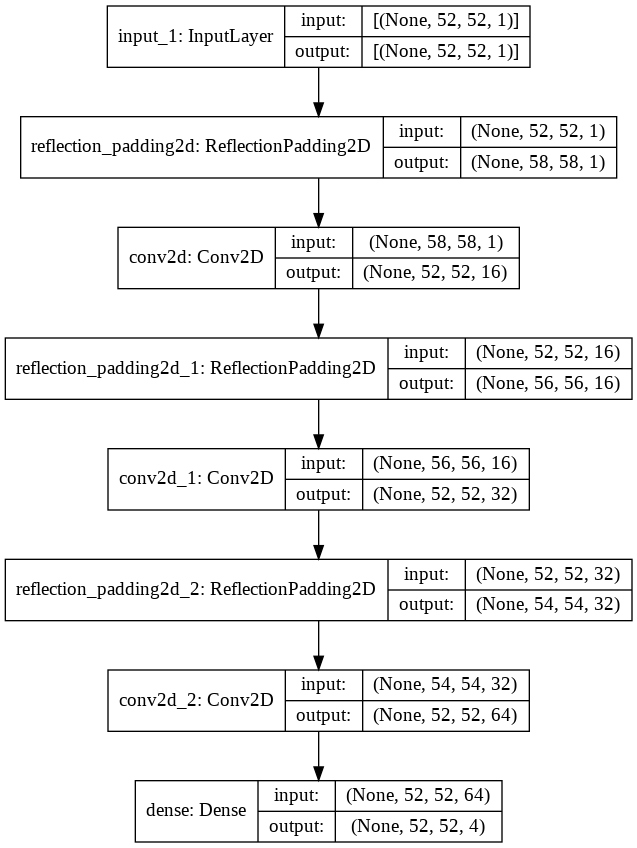

In [17]:
from tensorflow.keras.utils import plot_model

plot_model(myCNN,show_shapes=True)

Training of our model

In [18]:
train_y.shape

(3696, 52, 52, 4)

In [19]:
def generate_sample_weights(training_data, weights): 
  sample_weights = []
  d = 0
  for d1 in training_data:
    p = 0
    for d2 in d1:
      for d3 in d2:
        c = np.argmax(d3)
        if c != 3:
          p = 1
    if p == 1: 
      sample_weights.append(75)
    else:
      sample_weights.append(0.5)

  
  print(d)
  return np.asarray(sample_weights)

class_weights = {0 : 100 , 1 : 140 , 2 : 90 , 3 : 1}

In [20]:
class_weights[0]

100

In [21]:
w = generate_sample_weights(train_y, class_weights)



0


In [22]:
len(w)

3696

In [23]:
a = 0
for i in w:
  if i == 75:
    a = a+1
print(a)

2636


In [24]:
batch_size = 32

In [25]:
base_history = myCNN.fit(train_x, train_y, epochs=50, batch_size=batch_size, shuffle=True, validation_data=(val_x, val_y), verbose=1, sample_weight=w)

Epoch 1/50
116/116 [==============================] - 72s 613ms/step - loss: 7.6417 - accuracy: 0.9776 - val_loss: 0.0113 - val_accuracy: 0.9985
Epoch 2/50
116/116 [==============================] - 71s 610ms/step - loss: 0.7792 - accuracy: 0.9984 - val_loss: 0.0107 - val_accuracy: 0.9985
Epoch 3/50
116/116 [==============================] - 71s 612ms/step - loss: 0.7328 - accuracy: 0.9985 - val_loss: 0.0101 - val_accuracy: 0.9985
Epoch 4/50
116/116 [==============================] - 71s 613ms/step - loss: 0.7044 - accuracy: 0.9985 - val_loss: 0.0099 - val_accuracy: 0.9985
Epoch 5/50
116/116 [==============================] - 71s 610ms/step - loss: 0.6925 - accuracy: 0.9985 - val_loss: 0.0099 - val_accuracy: 0.9985
Epoch 6/50
116/116 [==============================] - 72s 625ms/step - loss: 0.6828 - accuracy: 0.9985 - val_loss: 0.0098 - val_accuracy: 0.9985
Epoch 7/50
116/116 [==============================] - 71s 609ms/step - loss: 0.6739 - accuracy: 0.9985 - val_loss: 0.0096 - val_ac

In [26]:
print(base_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [27]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('accuracy.png')
    plt.show()

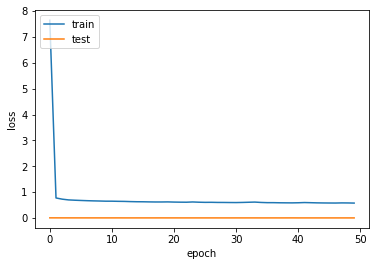

In [28]:
plot_history(base_history,['loss','val_loss'])

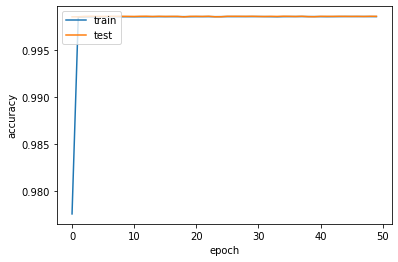

In [29]:
plot_history(base_history,['accuracy','val_accuracy'])

**Performance evaluation**

In [30]:
from sklearn.metrics import confusion_matrix , classification_report

y_pred = myCNN.predict(test_x)
classes = []
c = 0
for d1 in y_pred:
  for d2 in d1:
    for d3 in d2:
      classes.append(np.argmax(d3))
      if (np.argmax(d3)) == 1:
        c = c+1
print(c)

testo=[]
c2=0
for d1 in test_y:
  for d2 in d1:
    for d3 in d2:
      testo.append(np.argmax(d3))   
      if (np.argmax(d3)) == 1:
        c2 = c2+1   
print(c2)
classes[:5]




print("Classification Report: \n", classification_report(testo, classes, target_names=['SFG', 'AGN-steep','AGN-flap','background']))

11
48
Classification Report: 
               precision    recall  f1-score   support

         SFG       0.00      0.00      0.00        93
   AGN-steep       0.36      0.08      0.14        48
    AGN-flap       0.49      0.07      0.12      4479
  background       1.00      1.00      1.00   3121204

    accuracy                           1.00   3125824
   macro avg       0.46      0.29      0.31   3125824
weighted avg       1.00      1.00      1.00   3125824

